## Plot feature distribution over time

In [5]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,place_num,number,current_odds,current_place_odds,place,relevance,...,JockeyClassPurseRate,TrainerDistancePurseRate,TrainerSurfacePurseRate,TrainerTrackPurseRate,TrainerClassPurseRate,RaceClassDifference,HasJockeyChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,2017-07-01 14:45:00,2272774,8,3,1,4.0,1.6,5,5,...,1686.167169,0.000000,2177.999272,139.478058,2327.259017,0.0,1.0,63.0,1.4,81.0
1,1,2017-07-01 14:45:00,2272774,8,3,2,5.0,1.8,6,4,...,163.793328,3814.900821,3993.677538,5588.222189,830.850678,NaN,NaN,59.0,0.0,NaN
2,2,2017-07-01 14:45:00,2272774,8,3,3,6.5,2.1,3,15,...,1694.776847,4212.310547,1164.458934,2016.873370,646.527026,-1.0,1.0,59.0,0.0,NaN
3,3,2017-07-01 14:45:00,2272774,8,3,4,5.5,1.9,4,13,...,734.592253,NaN,670.376223,1715.991211,1021.703724,-1.0,1.0,59.0,0.0,NaN
4,4,2017-07-01 14:45:00,2272774,8,3,5,67.0,14.2,7,2,...,410.004578,NaN,114.578982,NaN,NaN,-1.0,1.0,56.7,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468475,468475,2022-10-23 18:15:00,5461321,9,3,6,3.5,1.5,3,28,...,232.346499,1131.553653,1155.288773,757.328585,2185.505760,1.0,1.0,71.7,2.3,NaN
468476,468476,2022-10-23 18:15:00,5461321,9,3,7,7.5,2.3,4,28,...,1506.448504,3177.794136,2055.044998,NaN,1229.419625,0.0,0.0,71.2,0.0,95.0
468477,468477,2022-10-23 18:15:00,5461321,9,3,9,4.0,1.6,9,20,...,1355.486454,686.914488,1238.631402,707.594206,1089.547063,0.0,0.0,68.9,0.0,92.0
468478,468478,2022-10-23 18:15:00,5461321,9,3,10,13.0,3.4,8,22,...,664.761117,403.702560,417.314570,95.768227,626.375277,0.0,1.0,65.3,0.0,84.0


<AxesSubplot:xlabel='Age', ylabel='year-month'>

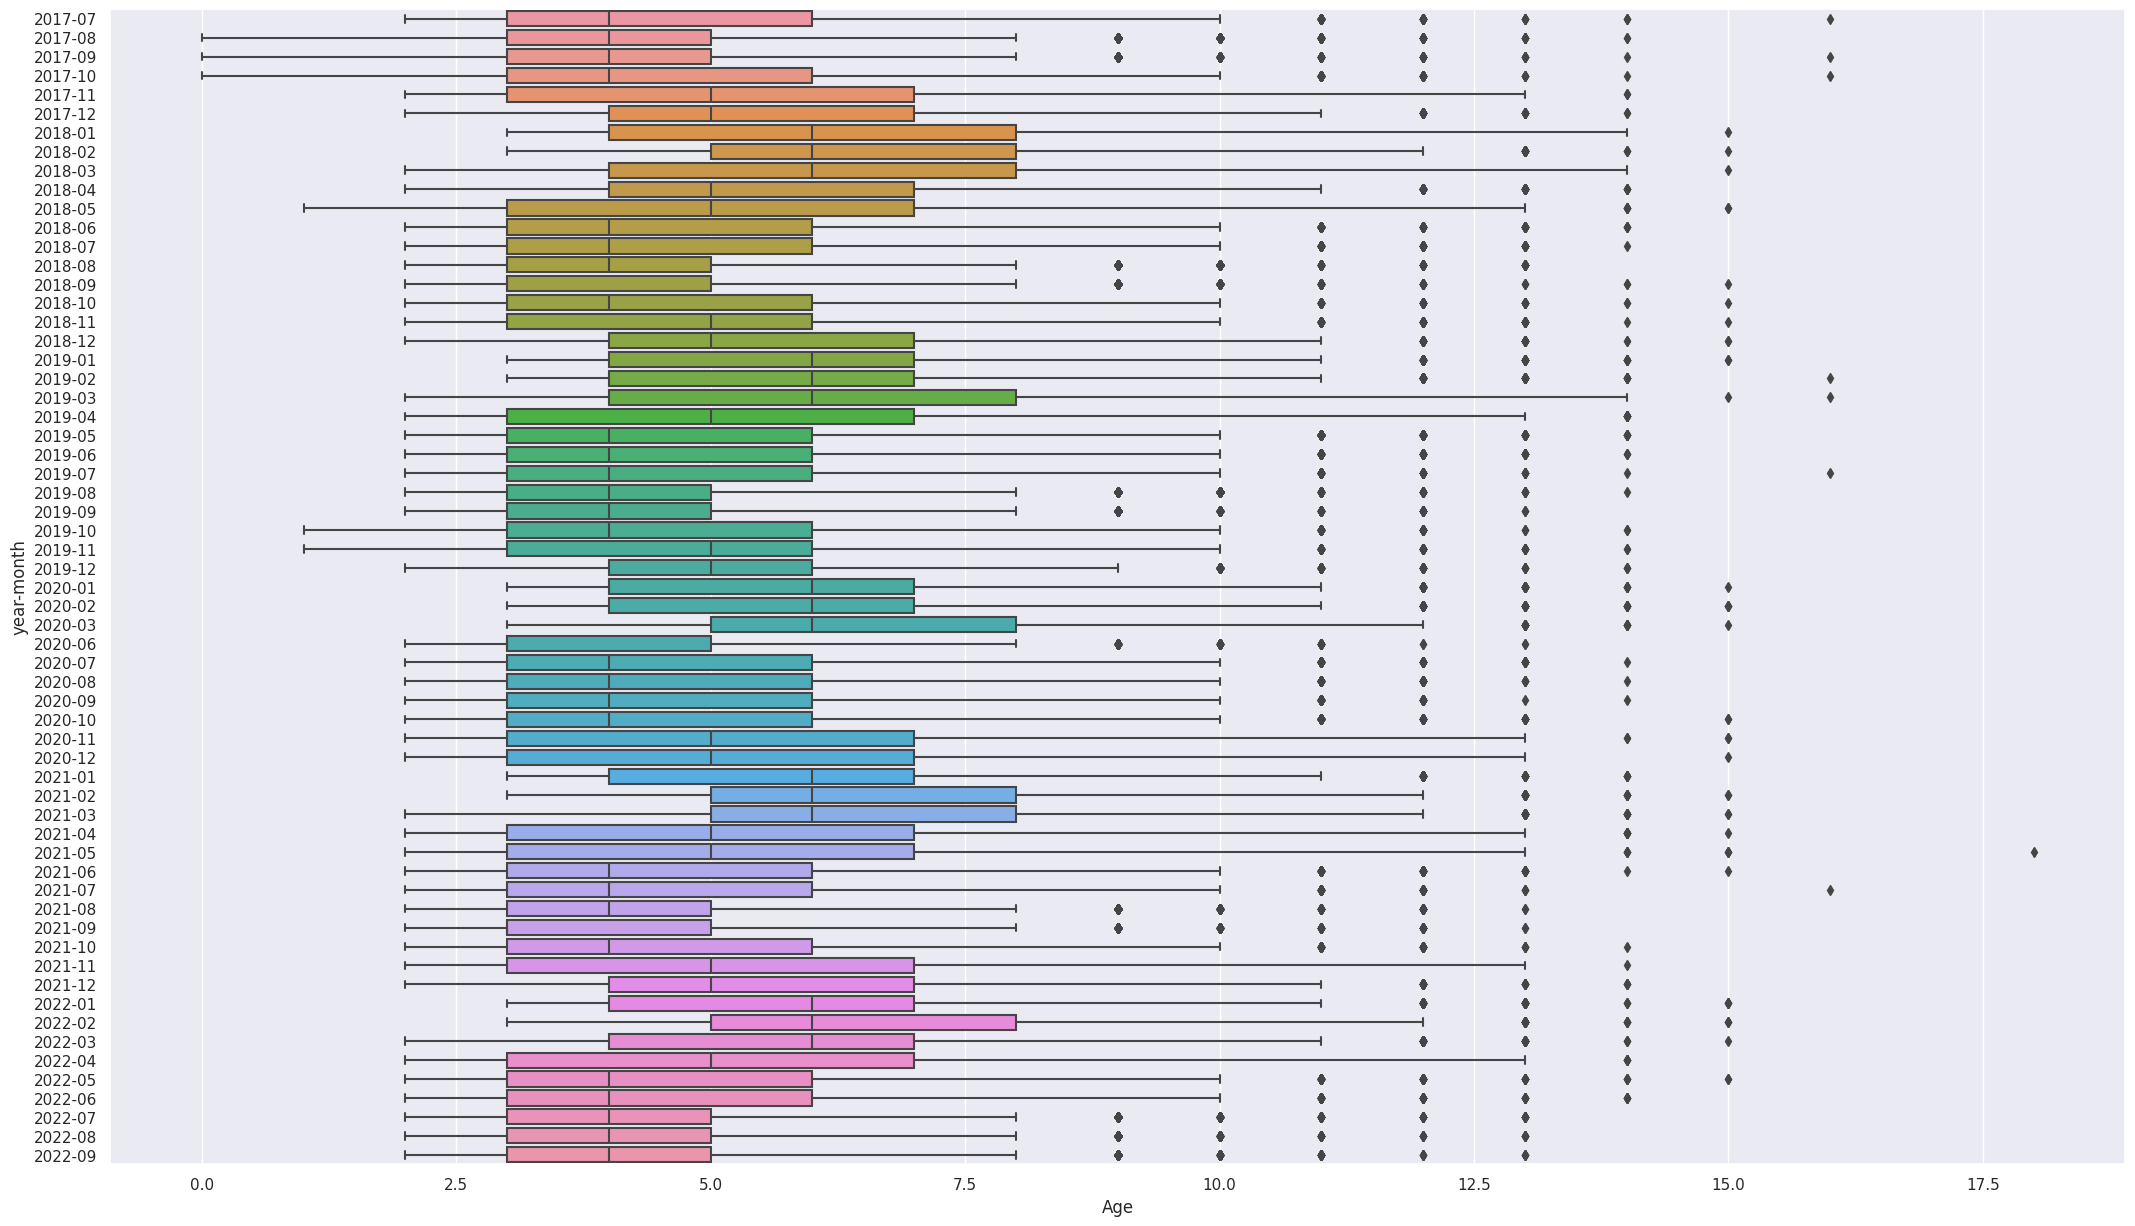

In [5]:
import seaborn as sns

COLUMN_NAME = "Age"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

#print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.set(rc={'figure.figsize':(26,15)})
sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

In [55]:
from numpy.random import normal
from scipy.stats import stats
from numpy import std
from math import isnan
from statistics import mean

speed_figures = list(races_df["CurrentSpeedFigure"].values)
speed_figures = [speed_figure for speed_figure in speed_figures if not isnan(speed_figure)]
print(mean(speed_figures))
print(std(speed_figures))

speed_figures_sample = normal(loc=-12.8, scale=20.38, size=10000)
stats.percentileofscore(speed_figures_sample, -20)

-12.800445569308796
20.38557260828779


/tmp/ipykernel_327506/3946010061.py:13: DeprecationWarning: Please use `percentileofscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.percentileofscore(speed_figures_sample, -20)


36.68

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458


## Production sample inspection

In [6]:
import pandas as pd

production_race_df = pd.read_csv("../data/production_race_5461321.csv")

production_race_df

,Unnamed: 0,date_time,race_id,n_runners,place_num,number,current_odds,current_place_odds,place,relevance,...,DamSirePurseRate,HorseJockeyPurseRate,HorseBreederPurseRate,JockeyDistancePurseRate,JockeyTrackPurseRate,TrainerSurfacePurseRate,TrainerClassPurseRate,RaceClassDifference,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,2022-10-23 18:15:00,5461321,9,3,2,26.00,6.00,-1,0,...,1620.159148,0.000000,0.000000,3453.504481,259.090784,4732.666050,845.868287,0.0,0.0,110.0
1,1,2022-10-23 18:15:00,5461321,9,3,3,5.50,2.20,-1,0,...,1846.719164,354.750726,120.693900,1713.073947,1701.319112,1389.892294,806.729807,0.0,0.0,127.0
2,2,2022-10-23 18:15:00,5461321,9,3,4,6.00,2.00,-1,0,...,2404.663215,748.620787,748.620787,302.274711,632.760155,742.068139,703.747114,0.0,3.2,100.0
3,3,2022-10-23 18:15:00,5461321,9,3,5,19.00,4.20,-1,0,...,2253.737031,860.388405,334.458379,352.998624,1188.757010,133.696030,372.331442,0.0,1.4,119.0
4,4,2022-10-23 18:15:00,5461321,9,3,6,3.50,1.40,-1,0,...,2332.167924,940.000000,1190.398874,0.000000,NaN,1155.288773,2185.505760,1.0,2.3,NaN
5,5,2022-10-23 18:15:00,5461321,9,3,7,7.50,2.60,-1,0,...,2404.663215,0.000000,0.000000,3264.419537,1889.333191,2055.044998,1229.419625,0.0,0.0,95.0
6,6,2022-10-23 18:15:00,5461321,9,3,9,4.33,1.66,-1,0,...,2670.028177,229.347140,290.411582,187.794415,583.741746,1238.631402,1089.547063,0.0,0.0,92.0
7,7,2022-10-23 18:15:00,5461321,9,3,10,13.00,3.00,-1,0,...,2101.846774,NaN,190.686092,399.635617,2989.208216,417.314570,626.375277,0.0,0.0,84.0
8,8,2022-10-23 18:15:00,5461321,9,3,11,51.00,7.60,-1,0,...,862.000615,1117.791278,717.090239,2763.675621,901.780236,607.524471,401.525517,0.0,0.0,81.0
